#Case: Mercado de Combustíveis - Leonardo Carvalho

##bibliotecas

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

##importação e tratamento dos dados

In [37]:
path = "vendas_distribuidoras_anp 1.xlsx"

#importação dos dados da planilha
diesel = pd.read_excel(io = path, sheet_name = "diesel")
gasolina = pd.read_excel(io = path, sheet_name = "gasolina")
etanol = pd.read_excel(io = path, sheet_name = "etanol")

In [38]:
def tratamento(dados, nome):

  id_vars = ['meses', 'regiao']
  anos = [coluna for coluna in dados.columns if coluna not in id_vars] #colocando os anos em uma lista

  dados_long = pd.melt(dados, id_vars = id_vars, value_vars = anos, var_name = 'ano', value_name = nome)

  dados_long['data'] = pd.to_datetime(dados_long['ano'].astype(str) + '-' + dados_long['meses'].astype(str), format = '%Y-%m')

  dados = dados_long[['data', 'regiao', nome]].dropna()

  return dados

In [39]:
diesel = tratamento(diesel, 'diesel')
gasolina = tratamento(gasolina, 'gasolina')
etanol = tratamento(etanol, 'etanol')

In [40]:
dados = diesel.merge(gasolina, on = ['data','regiao'], how = 'outer')
dados = dados.merge(etanol, on = ['data','regiao'], how = 'outer').dropna()
dados[['diesel', 'gasolina', 'etanol']] = dados[['diesel', 'gasolina', 'etanol']]/1000 #convertendo para milhões de litros
dados

,data,regiao,diesel,gasolina,etanol
0,2000-01-01,br,2562.814939,1810.572096,425.187481
1,2000-01-01,df,23.310896,39.257909,11.687930
2,2000-01-01,go,87.944946,58.254692,16.683495
3,2000-01-01,ma,46.337618,16.751080,1.596190
4,2000-01-01,mg,314.501824,182.555481,47.585405
...,...,...,...,...,...
2299,2021-04-01,mg,609.563778,229.135651,214.483780
2300,2021-04-01,mt,247.734649,42.516153,74.757740
2301,2021-04-01,pa,228.843820,93.903013,4.384226
2302,2021-04-01,sp,1052.103418,531.111657,774.377163


##item 1

In [41]:
dados.set_index('data', inplace = True)

In [42]:
#visualização das series
def plt_series(dados, combustivel):
  fig, axes = plt.subplots(3, 3, figsize=(13, 13))
  axes = axes.flatten()

  regioes = dados['regiao'].unique()

  for i, regiao in enumerate(regioes):

    df = dados[dados['regiao'] == regiao]

    axes[i].plot(df.index, df[combustivel])
    axes[i].set_title(f'milhões de litros vendidos {combustivel}: {regiao.upper()}')
    axes[i].grid(True)

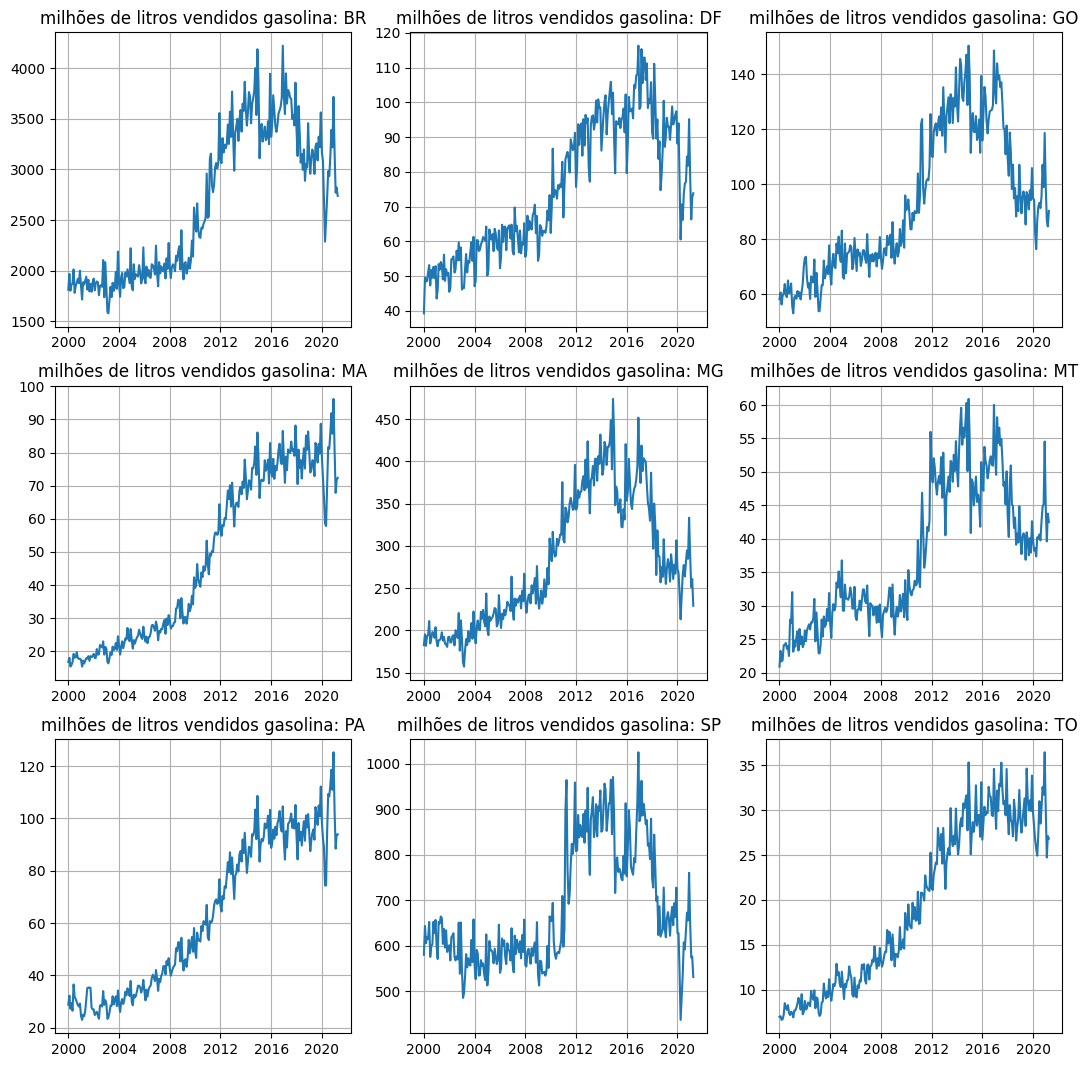

In [43]:
plt_series(dados, 'gasolina')

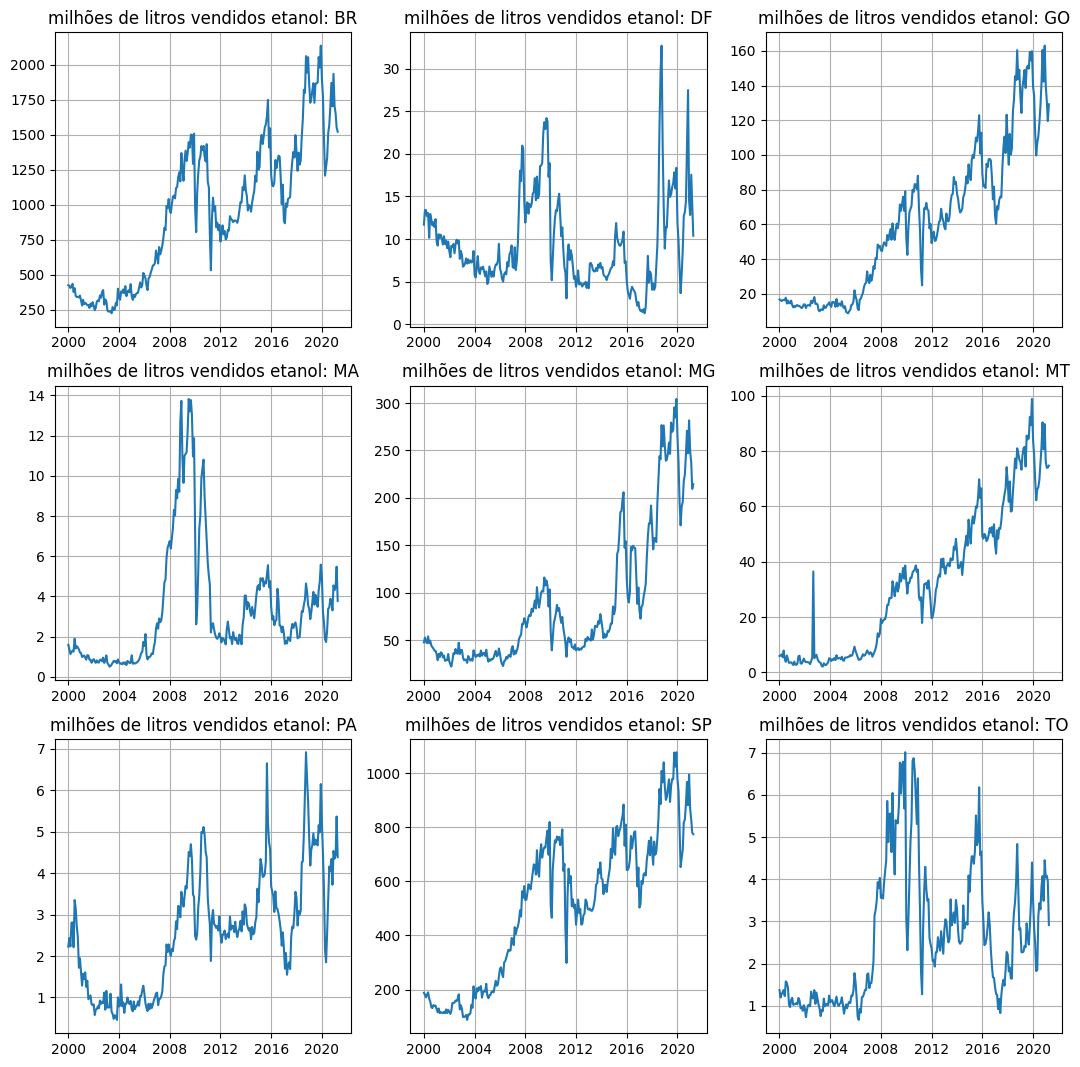

In [44]:
plt_series(dados, 'etanol')

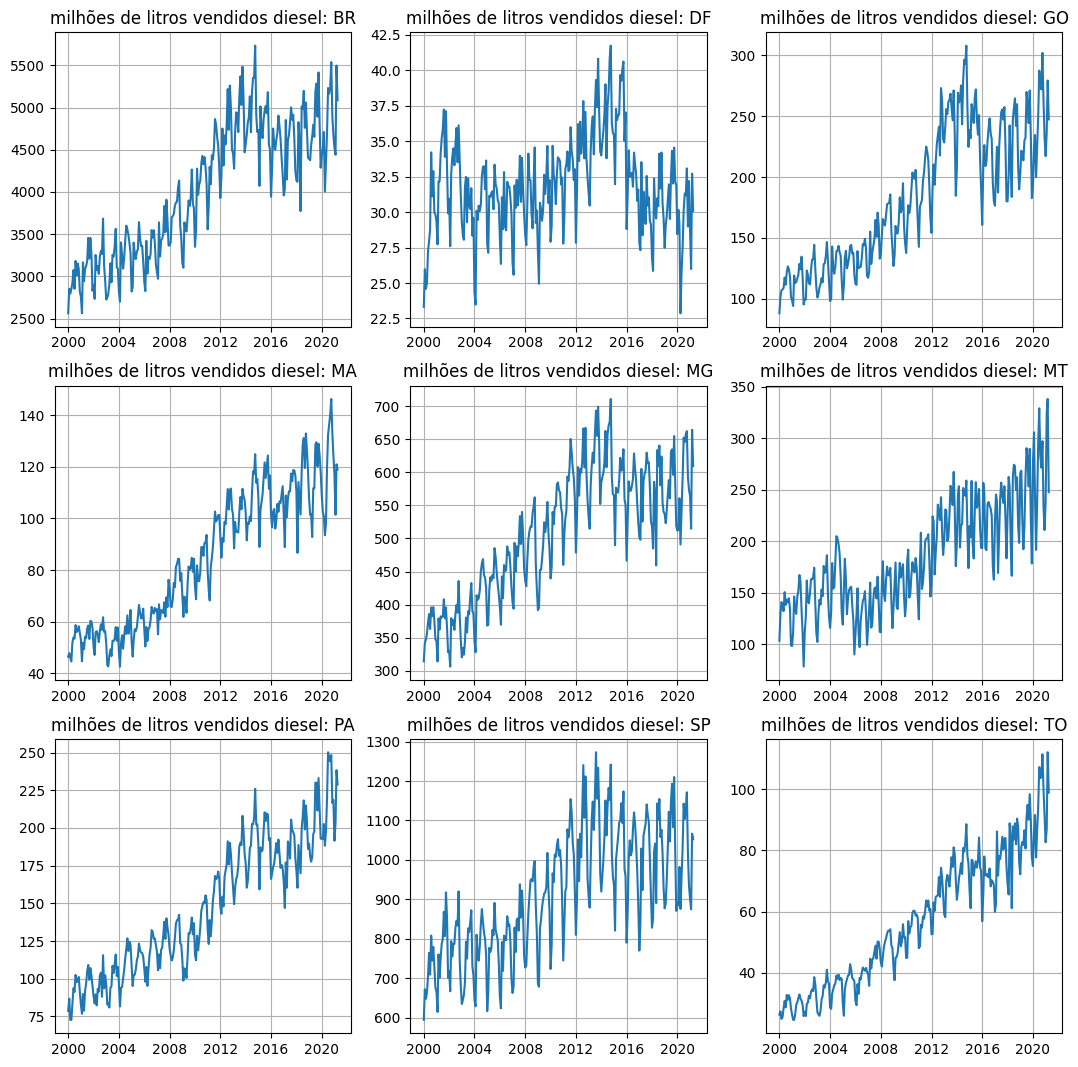

In [45]:
plt_series(dados, 'diesel')

In [46]:
#verificação da sazonalidade a partir do monthplot
def plt_season(dados, combustivel):

  regioes = dados['regiao'].unique()

  fig, axes = plt.subplots(3, 3, figsize=(13, 10), constrained_layout=True)

  for i, regiao in enumerate(regioes):

    df = dados[dados['regiao'] == regiao].resample('ME').sum().dropna()

    ax = axes[i // 3, i % 3]

    sm.graphics.tsa.month_plot(df[combustivel], ax=ax, ylabel='milhões de litros vendidos')
    ax.set_title(f'Monthplot {combustivel} região: {regiao.upper()}')

  plt.show()

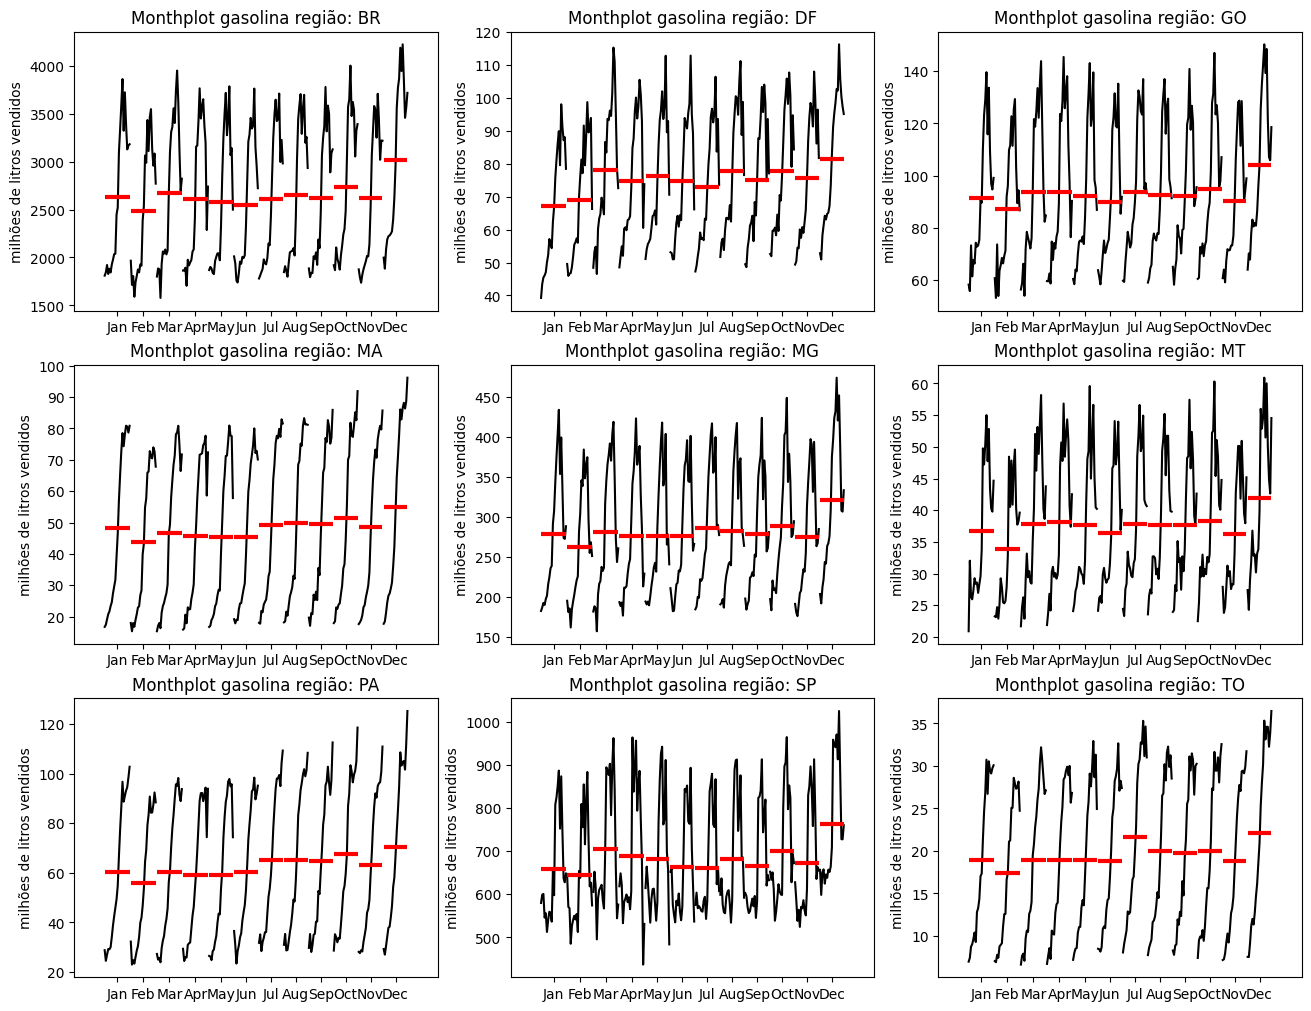

In [47]:
plt_season(dados, 'gasolina')

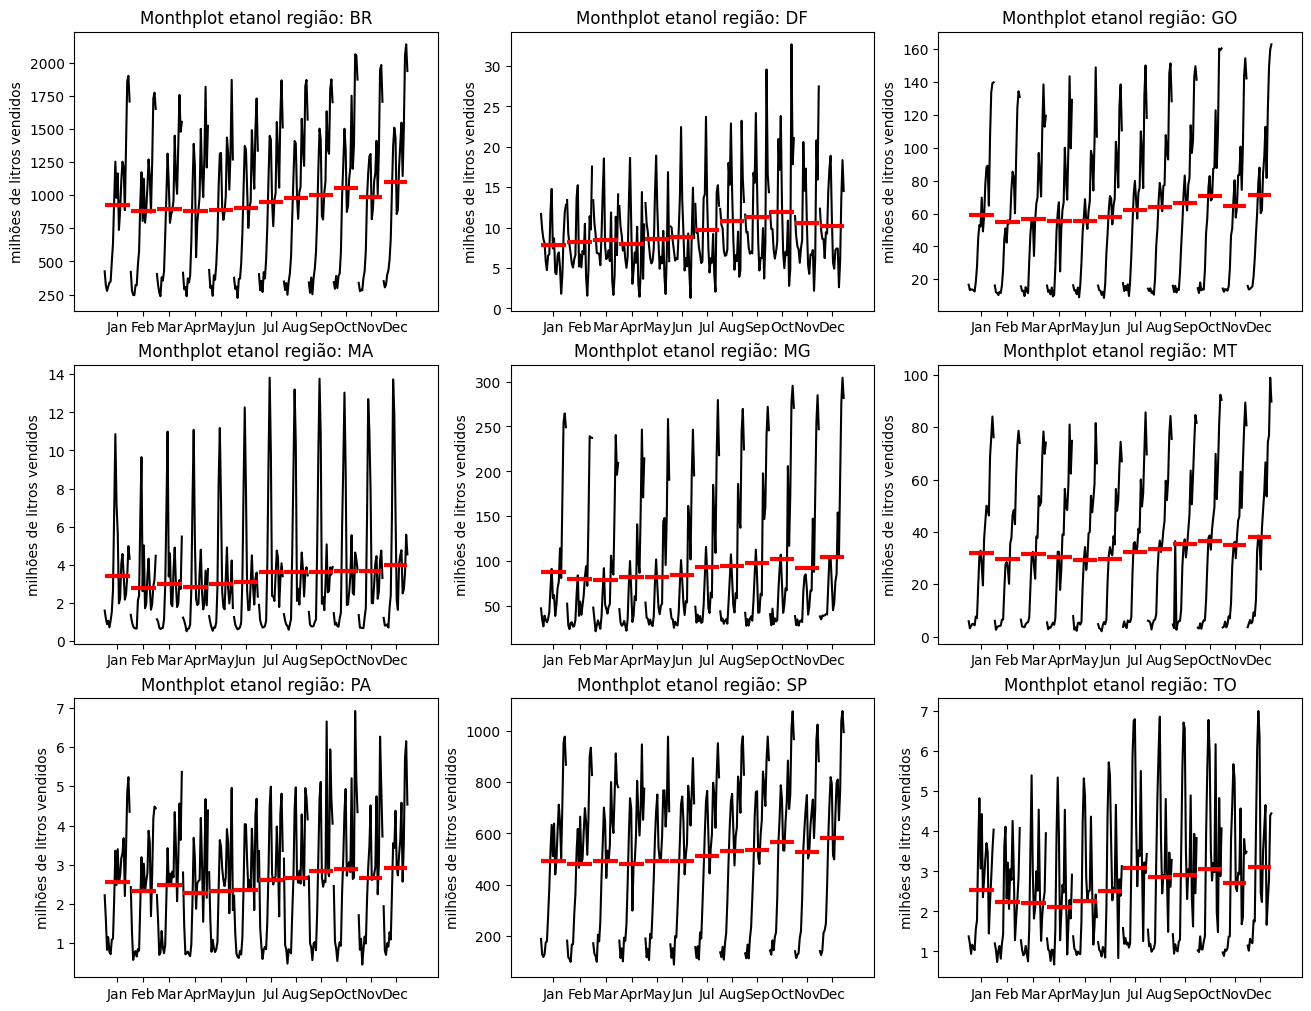

In [48]:
plt_season(dados, 'etanol')

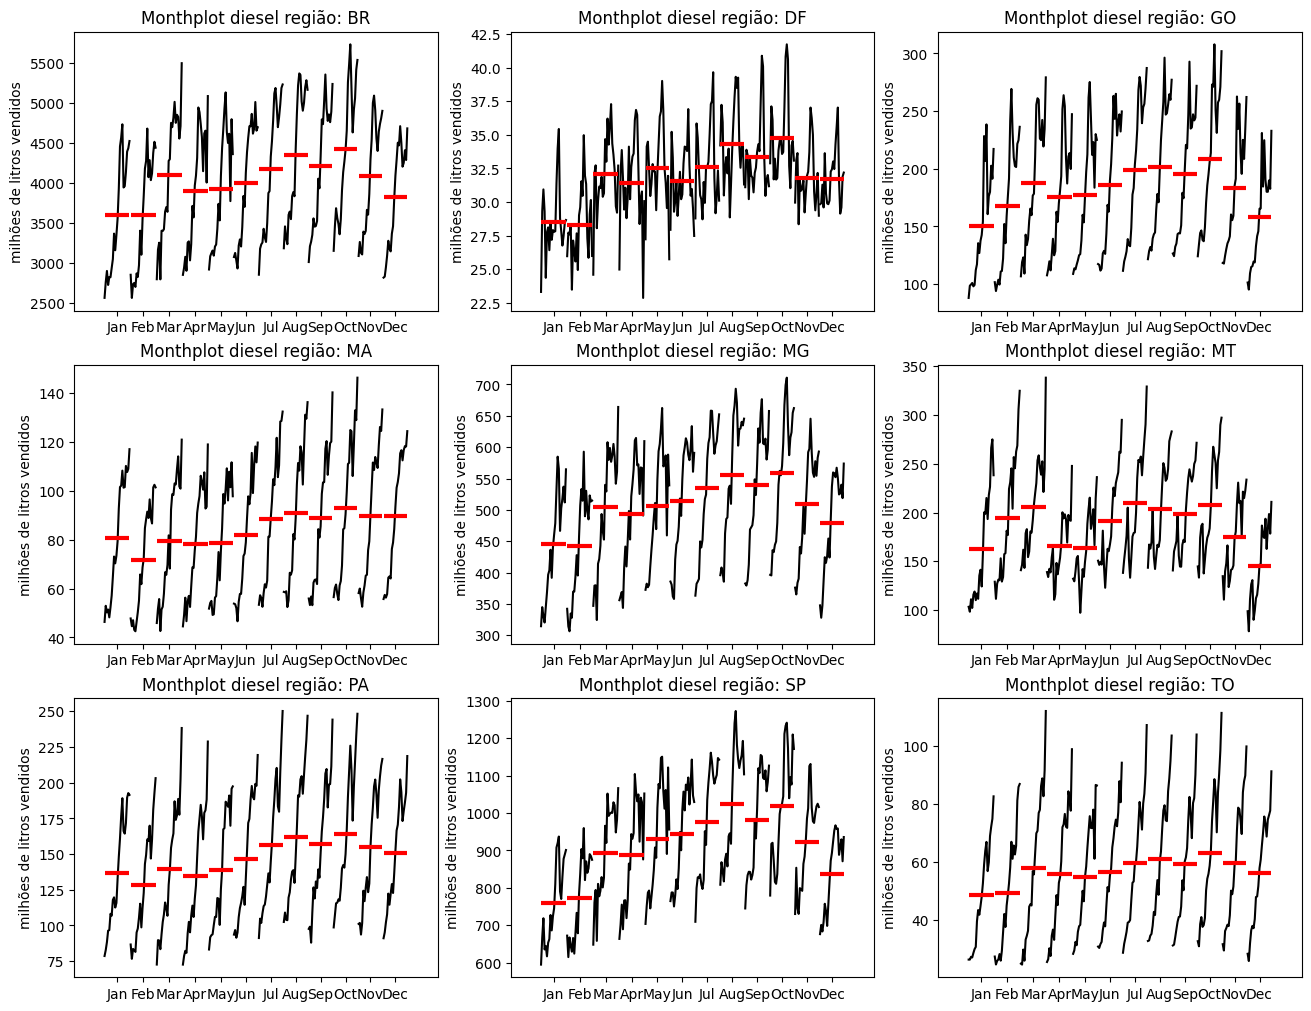

In [49]:
plt_season(dados, 'diesel')

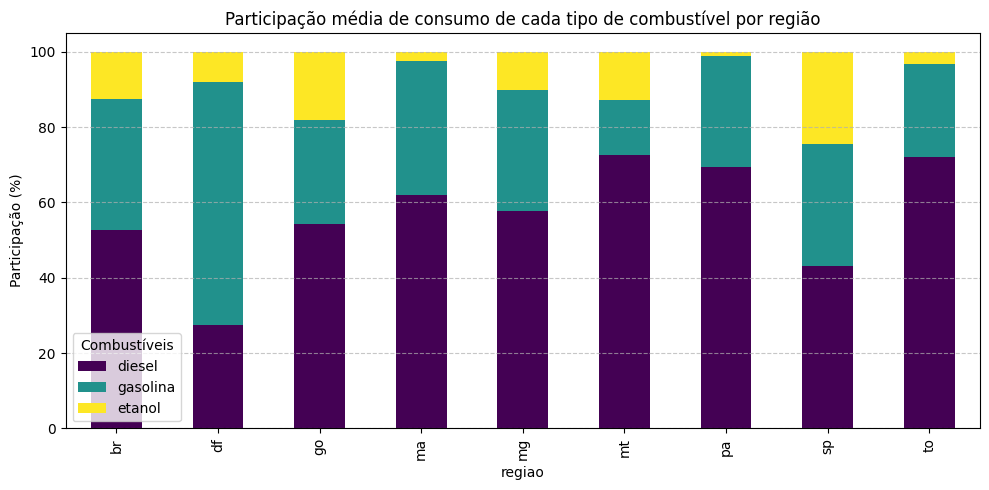

In [50]:
#distribuição do consumo por estado - proxy do consumo: venda de combustíveis

media_hist = dados.groupby('regiao')[['diesel', 'gasolina', 'etanol']].mean()

media_hist['total'] = media_hist.sum(axis=1)
part_pct = media_hist.div(media_hist['total'], axis=0) * 100

part_pct[['diesel', 'gasolina', 'etanol']].plot(
    kind='bar',
    stacked=True,
    figsize=(10, 5),
    colormap='viridis'
)

plt.title('Participação média de consumo de cada tipo de combustível por região')
plt.ylabel('Participação (%)')
plt.legend(title='Combustíveis')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

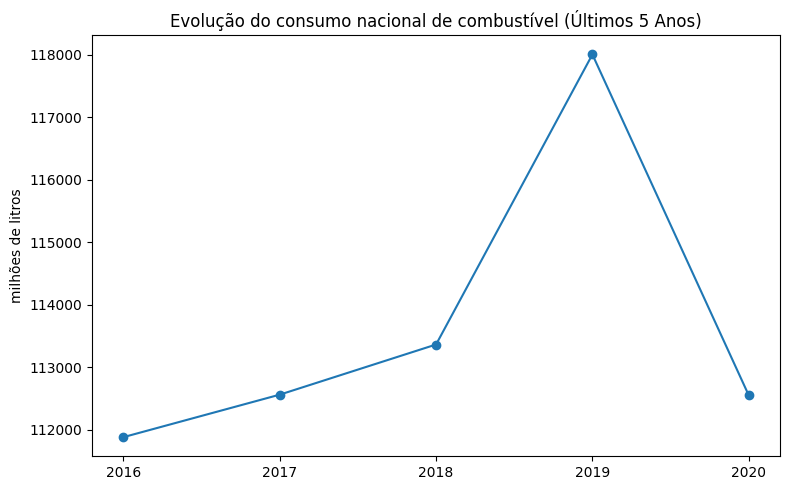

In [51]:
#proxy para tamanho do mercado: venda nacional de combustíveis
dados['total'] = dados[['diesel', 'gasolina', 'etanol']].sum(axis=1)
dados['ano'] = dados.index.year

venda_anual = dados.groupby(['ano', 'regiao'])['total'].sum().unstack()
venda_anual = venda_anual[venda_anual.index != 2021].tail(5)

plt.figure(figsize=(8, 5))
plt.plot(venda_anual.index, venda_anual.br, marker='o', linestyle='-')
plt.title('Evolução do consumo nacional de combustível (Últimos 5 Anos)')
plt.ylabel('milhões de litros')
plt.xticks(ticks=venda_anual.index, labels=venda_anual.index, rotation=0)
plt.tight_layout()
plt.show()

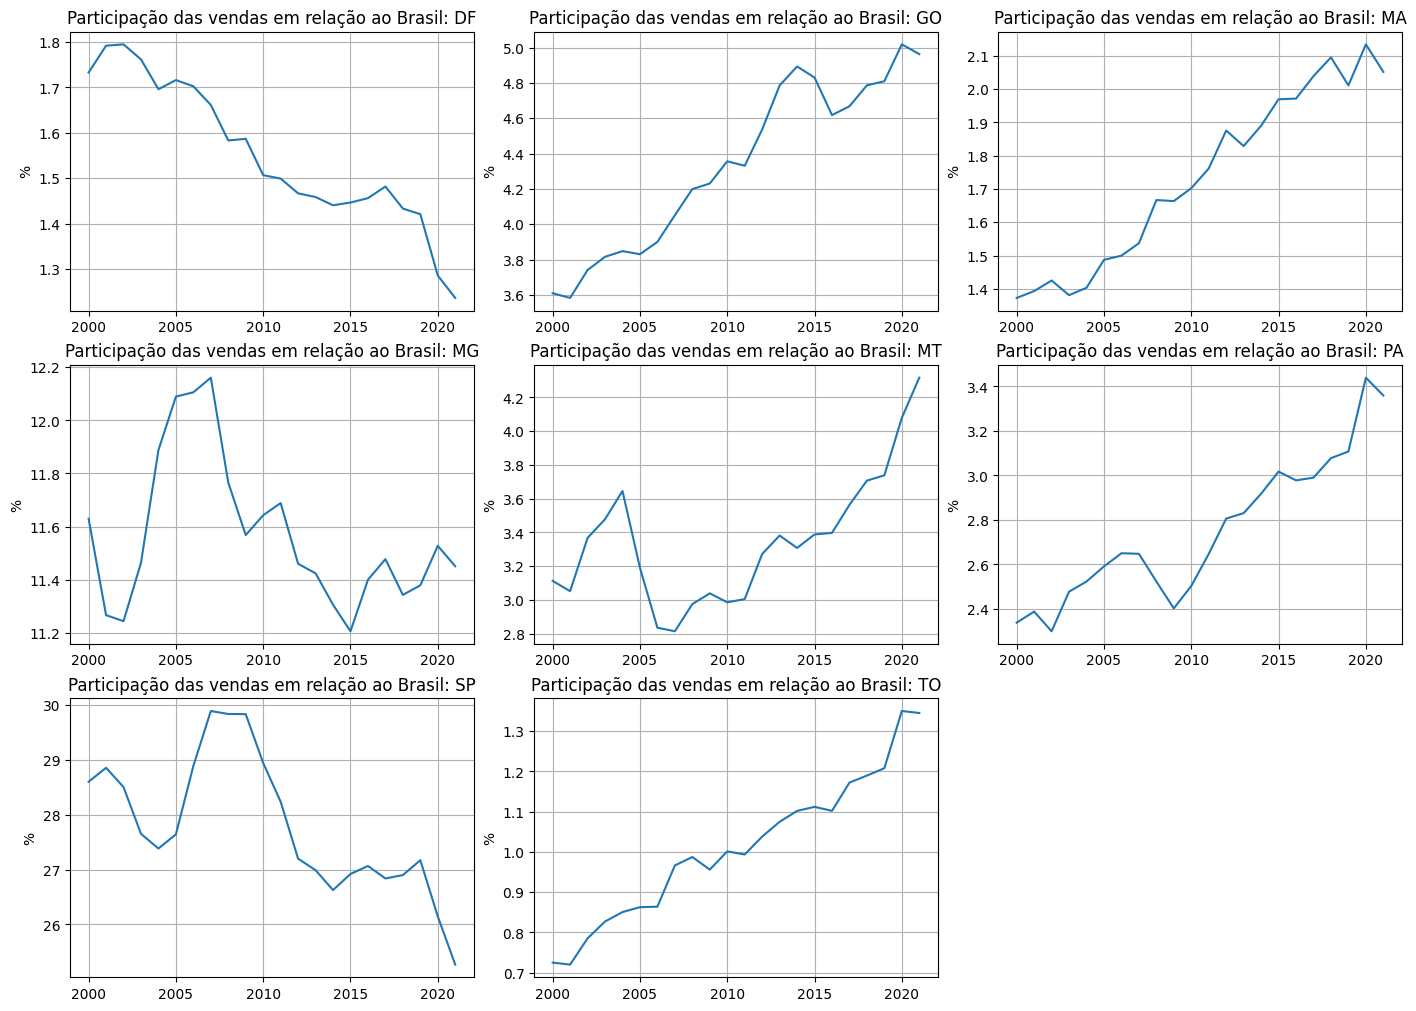

In [53]:
#participação de cada estado nas vendas nacionais ao longo do tempo(br)
venda_anual = dados.groupby(['ano', 'regiao'])['total'].sum().unstack()
venda_anual_br = venda_anual.br
venda_anual_regioes = venda_anual.drop('br', axis=1)

part_pct = (venda_anual_regioes.div(venda_anual_br, axis=0)) * 100

regioes = part_pct.columns

fig, axes = plt.subplots(3, 3, figsize=(14, 10), constrained_layout=True)

for i, regiao in enumerate(regioes):
    ax = axes[i // 3, i % 3]

    ax.plot(part_pct.index, part_pct[regiao], label=f'{regiao.upper()}')
    ax.set_title(f'Participação das vendas em relação ao Brasil: {regiao.upper()}')
    ax.set_ylabel('%')
    ax.grid(True)

for j in range(len(regioes), len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])